In [4]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.8.1+cpu False


In [3]:
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from PIL import Image
from matplotlib.pyplot import imshow
import json

#import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

print("finish importing")

finish importing


# Prepare Data

In [1]:
'''
The file structure of the dataset
coco (DATA_ROOT)
    L modified_train2017.json
    L modified_val2017.json
    L image/
'''
DATA_ROOT = './coco'

In [ ]:
register_coco_instances("modify_coco_train", {}, f"{DATA_ROOT}/modified_train2017.json", f"{DATA_ROOT}/image")
#register_coco_instances("modify_coco_val"  , {}, f"{DATA_ROOT}/jmodified_val2017.json"  , f"{DATA_ROOT}/image")

In [8]:
with open('./modified_category.json', 'r') as f:
    NUM_CLASSES = len(json.load(f))
print(f"NUM_CLASSES = {NUM_CLASSES}")

NUM_CLASSES = 7


# Prepare for Training

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("modify_coco_train",)
cfg.DATASETS.TEST  = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES 
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.OUTPUT_DIR = './model'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import datetime
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, f"model_final_{datetime.datetime.now()}.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Check the Model on Robosuite Example 

(256, 256, 3)


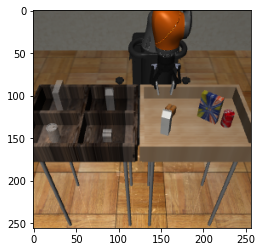

In [3]:
pic = np.asarray(Image.open('name_0.png'))
imshow(pic)
#pic = pic.transpose((2,0,1))
print(pic.shape)

In [4]:
outputs = predictor(pic)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
print(outputs['instances'])

NameError: name 'predictor' is not defined

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(pic[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
imshow(out.get_image()[:, :, ::-1])